# 🔱 Bluetrip

## 💡 Explicação do projeto
O Bluetrip é uma aplicação móvel de turismo focada em oceanos, rios e lagos. Seu objetivo é fornecer aos usuários informações detalhadas e interativas sobre pontos turísticos aquáticos, eventos, comércios locais e espécies marinhas. A aplicação inclui um scanner inovador de QRCode que permite aos usuários renderizar modelos 3D de espécies ou partes específicas de pontos turísticos, acompanhados de informações relevantes, enriquecendo a experiência de exploração e aprendizado. Além disso também disponibiliza um Scanner de espécies.

Entretanto, para se adequar com as necessidades da a aplicação optamos por seguir com a primeira opção proposta:
Detecção e Classificação de Espécies: Utilizar técnicas de Deep Learning para identificar e classificar espécies marinhas em imagens subaquáticas ou superficiais. O objetivo é desenvolver um modelo que possa distinguir entre diferentes espécies, ajudando a monitorar a biodiversidade e detectar espécies ameaçadoras, invasoras, poluidores ou corrosão dos corais entre outros habitats.

## 📖 Metodologia utilizada
A aplicação Bluetrip utiliza técnicas avançadas de inteligência artificial para identificar espécies aquáticas a partir de imagens, integrando o framework de deep learning TensorFlow/Keras com a biblioteca FastAPI para criar uma API robusta e eficiente. A seguir, descrevemos a metodologia empregada para desenvolver este componente da aplicação.

## 👥 Equipe
Este projeto está sendo desenvolvido pelos seguintes membros:

- RM98110 - André Rohregger Machado (2TDSPV)
- RM99565 - Erick Nathan Capito Pereira (2TDSPV)
- RM550841 - Lucas Araujo Oliveira Silva (2TDSPW)
- RM551886 - Victor Luca do Nascimento Queiroz (2TDSPV)
- RM99455 - Vinícius Martins Torres Abdala (2TDSPV)

## 🎲 Datasets utilizados

- https://www.kaggle.com/datasets/larusso94/shark-species
- https://www.kaggle.com/datasets/markdaniellampa/fish-dataset?resource=download-directory

## 🔢 Classe de dados

### Tubarões
- Tubarão-peregrino
- Tubarão-de-ponta-preta
- Tubarão-azul
- Tubarão-touro
- Tubarão-martelo
- Tubarão-limão
- Tubarão-mako
- Tubarão-enfermeiro
- Tubarão-tigre-da-areia
- Tubarão-raposa
- Tubarão-tigre
- Tubarão-baleia
- Tubarão-branco
- Tubarão-de-ponta-branca

### Peixes
- Bangus
- Carpa Cabeçuda
- Barbo Manchada
- Bagre
- Percha Trepadeira
- Barbudo-de-Quatro-Dedos
- Enguia de Água Doce
- Percaleta de Vidro
- Gobídeo
- Peixe Dourado
- Gurami
- Carpa Herbívora
- Baiacu Verde de Pontos
- Carpa Indiana
- Tarpão Indo-Pacífico
- Jaguarete
- Peixe-Lixeiro
- Peixe-Faca
- Peixe-Cachimbo de Focinho Longo
- Peixe-Mosquito
- Peixe-Lama
- Tainha
- Pangácio
- Perca
- Peixe-Scat
- Barbo Prateado
- Carpa Prateada
- Perca Prateada
- Cabeça-de-Cobra
- Pampo
- Tilápia

## Configuração do Ambiente e Importações
O código começa com as importações necessárias para o funcionamento da API. Utilizamos o TensorFlow/Keras para carregar e utilizar o modelo de machine learning, a biblioteca Pillow (PIL) para manipulação de imagens, e o FastAPI para criação da API.

In [3]:
import io

from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
from typing import Annotated

from fastapi import FastAPI, File
from fastapi.middleware.cors import CORSMiddleware

import uvicorn

## Carregamento do modelo gerado pelo Teachable Machine e processo de Labelling
Carregamos o modelo de classificação de imagens treinado previamente usando a ferramenta Teachable Machine do Google. Esse modelo está armazenado no arquivo keras_model.h5. Além disso, lemos os nomes das classes (labels) das espécies a partir de um arquivo de texto.

In [4]:
model = load_model("./model/keras_model.h5", compile=False)

In [5]:
class_names = open("./model/labels.txt", "r", encoding="utf8").readlines()

## Importação e configuração da imagem de teste
Nesse trecho de código, importamos uma imagem de teste representando uma espécie marinha (no caso, um dourado). Em seguida, redimensionamos e normalizamos a imagem para garantir que tenha o formato esperado pelo modelo.

In [6]:
image = Image.open("./test/dourado.jpeg").convert("RGB")

size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

image_array = np.asarray(image)
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
data[0] = normalized_image_array

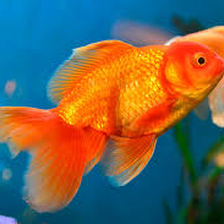

In [7]:
image

## Realiza a predição do modelo
Utilizando o modelo treinado, realizamos a predição da espécie marinha presente na imagem de teste. Após identificar a classe com maior probabilidade, exibimos o nome da espécie e a confiança da predição.

In [8]:
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

1/1 [==============================] - 1s 919ms/step


In [9]:
print(f"A espécie marinha da imagem escolhida é '{class_name[2:].strip()}' com uma confiança de {(confidence_score * 100)}%")

A espécie marinha da imagem escolhida é 'Peixe Dourado' com uma confiança de 100.0%


## Instanciando o FastAPI

In [10]:
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

## Criação das rotas para conexão com o front-end

### Rota de status para verificar se a aplicação está sendo executada
#### [GET] /status

In [11]:
@app.get("/status")
async def app_status():
    return 'ok'

### Rota para predição de imagem enviada no corpo da requisição
#### [POST] /identify-specie - file: File

In [12]:
@app.post("/identify-specie")
async def identify_specie(file: Annotated[bytes, File()]):
    image = Image.open(io.BytesIO(file)).convert("RGB")

    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    data[0] = normalized_image_array

    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index][2:].strip()
    confidence_score = prediction[0][index]

    return {
        "name": class_name,
        "score": round(confidence_score * 100, 3),
        "type": "Tubarão" if class_name.startswith("Tubarão") else "Peixe"
    }

## Execução do servidor HTTP do FastAPI utilizando Uvicorn

In [10]:
if __name__ == "__main__":
    uvicorn.run("app:app", host="127.0.0.1", port=8000, reload=True)

INFO:     Will watch for changes in these directories: ['d:\\projects\\courses\\fiap\\global-solution\\ai']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [282348] using WatchFiles
